In this project we will be creating a neural network to translate from Dzongkha to English. We have referred from NLP FROM SCRATCH: TRANSLATION WITH A SEQUENCE TO SEQUENCE NETWORK AND ATTENTION by  Sean Robertson.

Link to the source: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html 

This is made possible by the simple but powerful idea of the sequence to sequence network, in which two recurrent neural networks work together to transform one sequence to another. An encoder network condenses an input sequence into a vector, and a decoder network unfolds that vector into a new sequence.

[KEY: > input, = target, < output]

Dzongkha: ལན འདི གིས ཁོ ཁོང་ཁྲོ ལང བཅུག ནུག 

Actual: This answer made him angry.

Predicted: This answer made him angry.


To improve upon the model we will use an attention mechanism, which lets the decoder learn to focus over a specific range of the input sequence.

#Requirements

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
import os
import re

import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm

#Loading data files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
col_names=['English','Dzongkha']
df = pd.read_csv('drive/My Drive/AI/eng-dzo.csv', names=col_names)

In [ ]:
df = df.iloc[:100000,:]
df.head()

,English,Dzongkha
0,That's where I live.,ང་ སྡོད་ ས་ ནཱ་ ལུ་ ཨིན །
1,The cat is adorable.,བྱི་ལི་ འདི་ # ཡིད་ཁར་འོང་ཏོག་ཏོ་ འདུག །
2,The cat is not dead.,བྱི་ལི་ འདི་ མ་ ཤི་ བས །
3,The cat is sleeping.,བྱི་ལི་ འདི་ ཉལ་ ནུག །
4,The chair is broken.,རྐང་ཁྲི་ འདི་ ཆག་ ནུག །


In [ ]:
df.tail(10)

,English,Dzongkha
19990,Why is everyone looking at us?,མི་ ག་ར་ ང་བཅས་ ལུ་ ག་ཅི་སྦེ་ ལྟཝ་ ཨིན་ན །
19991,Why is he being so nice to me?,ཁོ་ ང་ ལུ་ ག་ཅི་སྦེ་ ལེགས་ཤོམ་ འབདཝ་ ཨིན་ན །
19992,Why is insurance so important?,ཉེན་བཅོལ་ ག་ཅི་སྦེ་ གནམ་མེད་ས་མེད་ ཁག་ ཆེཝ་ ཨི...
19993,Why should Dorji sing that song?,རྡོ་རྗེ་ ག་ཅི་སྦེ་ ཞབས་བྲོ་ དེ་ འཐེན་ དགོཔ་ ཨི...
19994,Why should there be a problem?,ག་ཅི་སྦེ་ དཀའ་ངལ་ འབྱུང་ ནི །
19995,Why should we study economics?,ང་བཅས་ ག་ཅི་སྦེ་ དཔལ་འབྱོར་རིག་པ་ ལྷབ་ དགོཔ་ ཨ...
19996,Why wasn't I informed earlier?,ང་ ལུ་ སྔ་གོང་ ལས་ ག་ཅི་སྦེ་ མ་ སླབ །
19997,Why were you absent yesterday?,ཁྱོད་ ཁ་ཙ་ ག་ཅི་སྦེ་ མེདཔ་ སྨོ །
19998,Why were you holding his hand?,ཁྱོད་ ག་ཅི་སྦེ་ ཁོ་ གི་ ལགཔ་ གཟུངམ་ སྨོ །
19999,Why weren't we told the truth?,ང་བཅས་ ལུ་ བདེན་པ་ འདི་ ག་ཅི་སྦེ་ མ་ སླབ་ སྨོ །


#Data Preprocessing

we will be representing each word in a language as a one-hot vector, or giant vector of zeros except for a single one (at the index of the word). Compared to the dozens of characters that might exist in a language, there are many many more words, so the encoding vector is much larger. We will however cheat a bit and trim the data to only use a few thousand words per language.

We’ll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called **Lang** which has word → index (**word2index**) and index → word (**index2word**) dictionaries, as well as a count of each word **word2count** which will be used to replace rare words later.

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[.]",r' ',s)
    s = re.sub(r"[^a-zA-Z]+", r" ", s)
    s = re.sub(r"[0-9]+", r"", s)
    return s

In [ ]:
def cleanerDz(line):
  
  line = re.sub(r'་\s*[& ]',r' ',line)
  line=re.sub(r'[\s]+',r' ',line)
  line=re.sub(r'།',r'',line)
  line=re.sub(r'\s#\s',r' ',line)

  return line

To read the data file we will split the file into lines, and then split lines into pairs. The files is in English → Dzongkha Language, so if we want to translate from Dzongkha Language → English we added the reverse flag to reverse the pairs.

In [ ]:
def readLangs(lang1, lang2, reverse=True):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('drive/My Drive/AI/%s-%s.csv' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')


    # Split every line into pairs and normalize
    #pairs = [[normalizeString(s) for s in l.split(',')] for l in lines]
    pairs = []
    for l in lines:
        transcript = l.split(',')
        #print(transcript)
        eng = normalizeString(transcript[0])
        dzo = cleanerDz(transcript[1])
        
        temp_arry = [eng,re.sub(r"\"",r' ',dzo)]
        pairs.append(temp_arry)

    print(eng,dzo)
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
       
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a lot of example sentences and we want to train something quickly, we’ll trim the data set to only relatively short and simple sentences. Here the maximum length is 22 words (that includes ending punctuation) and we’re filtering to sentences that translate to the form “I am” or “He is” etc. (accounting for apostrophes replaced earlier).

In [ ]:
MAX_LENGTH = 30

eng_prefixes = (
    "aren't","are not", 
    "can't","cannot", 
    "couldn't","could not",
    "couldnt","could not", 
    "didn't","did not", 
    "doesn't","does not", 
    "doesnt","does not", 
    "don't","do not", 
    "hadn't","had not", 
    "hasn't","has not", 
    "haven't","have not", 
    "havent","have not", 
    "he'd" , "he would", 
    "he'll" , "he will", 
    "he's","he is", 
    "i'd" , "I would",
    "i'd" , "I had", 
    "i'll" , "I will", 
    "i'm" , "I am", 
    "isn't" , "is not", 
    "it's" , "it is", 
    "it'll","it will", 
    "i've" , "I have", 
    "let's" , "let us", 
    "mightn't" , "might not", 
    "mustn't" , "must not", 
    "shan't" , "shall not", 
    "she'd" , "she would", 
    "she'll" , "she will", 
    "she's" , "she is", 
    "shouldn't" , "should not", 
    "shouldnt" , "should not", 
    "that's" , "that is", 
    "thats" , "that is", 
    "there's" , "there is", 
    "theres" , "there is", 
    "they'd" , "they would", 
    "they'll" , "they will", 
    "they're" , "they are", 
    "theyre", "they are", 
    "they've" , "they have", 
    "we'd" , "we would", 
    "we're" , "we are", 
    "weren't" , "were not", 
    "we've" , "we have", 
    "what'll" , "what will", 
    "what're" , "what are", 
    "what's" , "what is", 
    "what've" , "what have", 
    "where's" , "where is", 
    "who'd" , "who would",
    "who'll" , "who will", 
    "who're" , "who are", 
    "who's" , "who is", 
    "who've" , "who have", 
    "won't" , "will not", 
    "wouldn't" , "would not", 
    "you'd" , "you would", 
    "you'll" , "you will", 
    "you're" , "you are", 
    "you've" , "you have", 
    "'re", " are", 
    "wasn't", "was not", 
    "we'll"," will", 
    "didn't", "did not", 
    "tryin'","trying"
                
)
    


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

    Read csv file and split into lines, split lines into pairs

    Normalize text, filter by length and content

    Make word lists from sentences in pairs

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print(f"Read {len(pairs)} sentence pairs")
    # print(pairs)
    # pairs = filterPairs(pairs)
    # print("Trimmed to %s sentence pairs" % len(pairs))
    #print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'dzo', True)
print(random.choice(pairs))

Reading lines...
 why weren t we told the truth  "ང་བཅས ལུ བདེན་པ འདི ག་ཅི་སྦེ མ སླབ སྨོ "
Read 20000 sentence pairs
Counted words:
dzo 2564
eng 2677
[' ངེའི མིག་ཏོ འཇམ་ཏོང་ཏོ སྦེ གཅུཝ མས  ', ' my eyes get tired very easily ']


In [ ]:
pairs

[[' ང སྡོད ས ནཱ ལུ ཨིན  ', ' that s where i live '],
 [' བྱི་ལི འདི ཡིད་ཁར་འོང་ཏོག་ཏོ འདུག  ', ' the cat is adorable '],
 [' བྱི་ལི འདི མ ཤི བས  ', ' the cat is not dead '],
 [' བྱི་ལི འདི ཉལ ནུག  ', ' the cat is sleeping '],
 [' རྐང་ཁྲི འདི ཆག ནུག  ', ' the chair is broken '],
 [' རྒྱབ་སྐྱོར གྱི སྐད རྐྱབ ནི འདི མཚམས་འཇོག འབད ནུག  ',
  ' the cheering ceased '],
 [' གདམ་ཁ འདི ཁྱོད ལུ ཡོད  ', ' the choice is yours '],
 [' ང ལཱ འབད ས ནཱ ལུ ཨིན  ', ' that s where i work '],
 [' དེ་འབདཝ་ལས ང གིས བརྒྱུད་འཕྲིན བཏང ཡི  ', ' that s why i called '],
 [' དེ་འབདཝ་ལས ང གིས འབད ཡི  ', ' that s why i did it '],
 [' དེ་འབདཝ་ལས ང མི ཁོམ པས  ', ' that s why i m busy '],
 [' དེ་འབདཝ་ལས ང ནཱ སྡོད ཡི  ', ' that s why i m here '],
 [' དེ་འབདཝ་ལས ང འཕྱིས སོ ཡི  ', ' that s why i m late '],
 [' དེ་འབདཝ་ལས རྡོ་རྗེ ཡར སོ ཡི  ', ' that s why dorji left '],
 [' དེ་འབདཝ་ལས རྡོ་རྗེ གིས བཞག ཡི  ', ' that s why dorji quit '],
 [' ནཱི ཁྱོད ཀྱི བསམ་འཆར ཨིན པས  ', ' that s your opinion '],
 [' རྒྱང་མཐོང མེདཔ ཤོར སོ ནུག 

# Seq2Seq Model

The Encoder

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Attention Decoder

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Training

Preparing Training Data

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the model

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m} {s}'


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

# Plotting results

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# Evaluation

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    from nltk.translate.bleu_score import sentence_bleu
    for i in range(n):
        pair = random.choice(pairs)
        print('Dzongkha: ', pair[0])
        print('Actual: ', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('Predicted: ', output_sentence)
        act = pair[1].split()
        pred = output_sentence.split()
        print('Cumulative 1-gram: %f' % sentence_bleu([act], pred, weights=(1, 0, 0, 0)))
        print('Cumulative 2-gram: %f' % sentence_bleu([act], pred, weights=(0.5, 0.5, 0, 0)))
        print('Cumulative 3-gram: %f' % sentence_bleu([act], pred, weights=(0.33, 0.33, 0.33, 0)))
        print('Cumulative 4-gram: %f' % sentence_bleu([act], pred, weights=(0.25, 0.25, 0.25, 0.25)))
        score = sentence_bleu([act], pred)
        print(score)
        print('')

# Training and Evaluating

1 22.523382663726807 (- 19 15.327357292175293) (5000 6%) 3.4976
2 40.49393630027771 (- 17 23.210585951805115) (10000 13%) 2.7587
3 57.80874419212341 (- 15 51.23497676849365) (15000 20%) 2.2775
5 16.309457778930664 (- 14 29.851008892059326) (20000 26%) 1.8741
6 34.017127990722656 (- 13 8.034255981445312) (25000 33%) 1.5716
7 52.90068197250366 (- 11 49.35102295875549) (30000 40%) 1.2673
9 11.949620962142944 (- 10 30.799566813877618) (35000 46%) 1.0370
10 30.027656316757202 (- 9 11.274199277162552) (40000 53%) 0.8254
11 48.5595486164093 (- 7 52.373032410939686) (45000 60%) 0.6816
13 6.931157350540161 (- 6 33.46557867527008) (50000 66%) 0.5422
14 26.912749528884888 (- 5 15.240999828685517) (55000 73%) 0.4115
15 46.43671417236328 (- 3 56.60917854309082) (60000 80%) 0.3235
17 5.93400764465332 (- 2 37.83600117610058) (65000 86%) 0.2545
18 26.016169786453247 (- 1 19.001154984746563) (70000 93%) 0.1757
19 45.126917600631714 (- 0 0.0) (75000 100%) 0.1548


<Figure size 432x288 with 0 Axes>

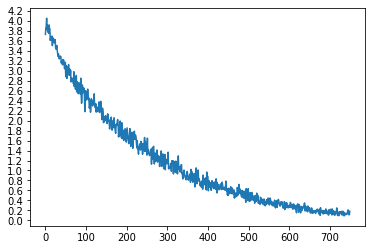

In [ ]:
%matplotlib inline
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

Dzongkha:   འདི འབྱུང་ཁུངས་མེདཔ བཟུམ འདུག  
Actual:   this seems stupid 
Predicted:   this seems stupid  <EOS>
Cumulative 1-gram: 0.750000
Cumulative 2-gram: 0.707107
Cumulative 3-gram: 0.632878
Cumulative 4-gram: 0.000000
8.636168555094496e-78

Dzongkha:   རྡོ་རྗེ གིས ཁྱོད ཀྱིས ཁོ ལུ ཆ་རོགས ཅིག འབད དགོཔ སྦེ ཨིན མས  
Actual:   dorji wants you to do him a favor 
Predicted:   dorji wants you to do him a favor  <EOS>
Cumulative 1-gram: 0.888889
Cumulative 2-gram: 0.881917
Cumulative 3-gram: 0.874762
Cumulative 4-gram: 0.863340
0.8633400213704505

Dzongkha:   མོ གིས ལོག མཇལ གེ ཟེར སླབ ནུག  
Actual:   she said goodbye 
Predicted:   she said goodbye  <EOS>
Cumulative 1-gram: 0.750000
Cumulative 2-gram: 0.707107
Cumulative 3-gram: 0.632878
Cumulative 4-gram: 0.000000
8.636168555094496e-78

Dzongkha:   ཁྱོད ཀྱིས ག་ཅི་སྦེ ང སྡོད དགོ ཟེར སླབ སྨོ  
Actual:   why would you want me to stay 
Predicted:   why would you want me to stay  <EOS>
Cumulative 1-gram: 0.875000
Cumulative 2-gram: 0.866025
Cum

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

Visualizing Attention

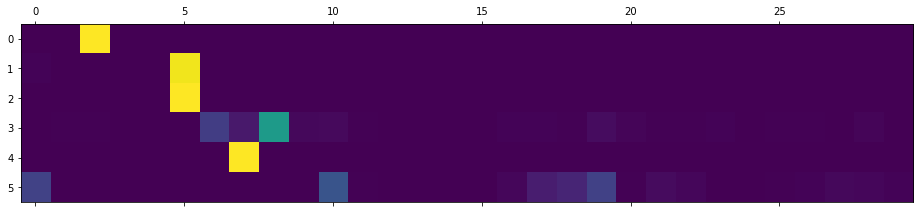

In [ ]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "མོ གིས ཁོ མ དགའ ནུག")
plt.matshow(attentions.numpy())

input = ང་བཅས གཅིག་ཁར སྡོད ཅི
output =  we were together to  <EOS>


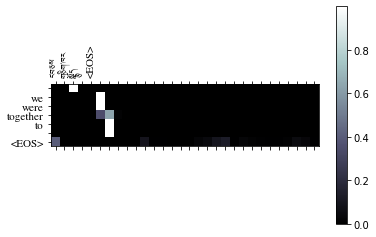

input = བྱ ལ་ལུ་ཅིག གིས འཕུར མི ཤེས
output =  dorji knows t know  <EOS>


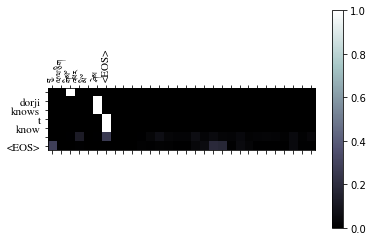

In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)
    
    prop = fm.FontProperties(fname='/content/drive/MyDrive/jomolhari.TTF')

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90,fontproperties=prop, size=10)
    ax.set_yticklabels([''] + output_words,fontproperties=prop, size=10)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("ང་བཅས གཅིག་ཁར སྡོད ཅི")

evaluateAndShowAttention("བྱ ལ་ལུ་ཅིག གིས འཕུར མི ཤེས")